In [7]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytoolsMH as ptMH
import pandas as pd
import seaborn as sns
import os,sys
import scipy.io
import scipy.stats as ss
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests
import json
import datetime, dateutil.parser

sns.set_style('whitegrid')
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

mpl.rc('pdf', fonttype=42) # embed fonts on pdf output 

r_ = np.r_

## covidtracking.com data

In [2]:
r = requests.get('https://covidtracking.com/api/states/daily')
data = r.json()
ctDf = pd.DataFrame(data)

In [19]:
dtV = pd.to_datetime(ctDf.loc[desIx,'date'], format='%Y%m%d')
dtV - dtV.iloc[-1]
;

''

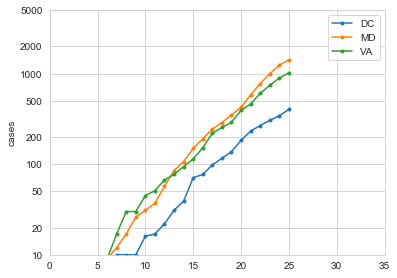

In [59]:

fig, ax = plt.subplots(figsize=r_[1,0.75]*6)


def plot_state(state='DC'):
    desIx = ctDf.state == state
    ys = ctDf.loc[desIx,'positive']
    dtV = pd.to_datetime(ctDf.loc[desIx,'date'], format='%Y%m%d')
    xs = (dtV - dtV.iloc[-1])
    ctDf.loc[desIx,'day0'] = xs
    xs = [x.days for x in xs]


    ax.plot(xs, ys, marker='.', label=state)
    ax.set_yscale('log')
    ax.set_ylabel('cases')


plot_state('DC')
plot_state('MD')
plot_state('VA')

ax.set_ylim([10,2000])
yt = [10,20,50,100,200,500,1000,2000,5000]
plt.yticks(yt,yt)
#ax.set_yticklabels(['%d'%x for x in yt])
ax.set_xlim([0,35])

plt.legend()
